# Multidimensional Metropolis-Hastings and Importance Sampling
This notebook demonstrates how to use the Metropolis-Hastings algorithm and importance sampling to estimate integrals in an arbitrary number of dimensions.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from numpy.random import Generator, MT19937
import time

# Initialize random number generator
seed = int(time.time())
rng = Generator(MT19937(seed))

In [23]:
# User-defined target PDF (multivariate standard normal by default)
def target_pdf(x):
    x = np.asarray(x)
    return np.exp(-0.5 * np.sum(x**2, axis=-1)) / (2 * np.pi) ** (x.shape[-1]/2)

# User-defined function to integrate (default: exp(-sum(x**2)))
def f(x):
    x = np.asarray(x)
    return np.exp(-np.sum(x**2, axis=-1))

# Multidimensional Metropolis-Hastings sampler
def metropolis_hastings(x0, thinning, burnin, N, step_size, target_pdf):
    d = len(x0)
    samples = []
    x_current = np.array(x0)
    for _ in range(N):
        x_proposed = x_current + rng.uniform(-step_size, step_size, size=d)
        acceptance_ratio = target_pdf(x_proposed) / target_pdf(x_current)
        if np.random.rand() < acceptance_ratio:
            x_current = x_proposed
        samples.append(x_current.copy())
    samples = samples[::thinning] #Keep every 'thinning'-th sample
    samples = samples[burnin:] #Discard the firs 'burnin' samples
    return np.array(samples)

# Importance sampling integration for multidimensional case
def importance_integration(f, target_pdf, m_chain):
    weights = f(m_chain) / target_pdf(m_chain)
    estimate = np.mean(weights)
    return estimate

# Example Usage

In [24]:
# Example usage: choose dimension d
D = 2  # Change this for different dimensions
N = 100_000
x0 = np.zeros(D)
step_size = 3.0
thinning = 1
burnin = int(N * 0.1)

m_chain = metropolis_hastings(x0, thinning, burnin, N, step_size, target_pdf)
Integral = importance_integration(f, target_pdf, m_chain)
print(f"Estimated integral in {D}D: {Integral}")
print("Actual value is ", np.pi ** (D/2))


Estimated integral in 2D: 3.1345874431553864
Actual value is  3.141592653589793


# Integral Estimate vs N for a chosen dimension

In [25]:

# Plot convergence of the estimated value to the actual value of pi^(3/2) for D=3
D = 10
actual_value = np.pi ** (D / 2)
N_values = np.logspace(2, 6, 30, dtype=int)
num_repeats = 10  # Number of repeated runs for error bars
integral_estimates = []
std_errors = []

x0 = np.zeros(D)
step_size = 3.0
thinning = 1


for N in N_values:
    estimates = []
    for _ in range(num_repeats):
        m_chain = metropolis_hastings(x0, thinning, int(0.1*N), N, step_size, target_pdf)
        estimate = importance_integration(f, target_pdf, m_chain)
        estimates.append(estimate)
    integral_estimates.append(np.mean(estimates))
    std_errors.append(np.std(estimates) / np.sqrt(num_repeats))



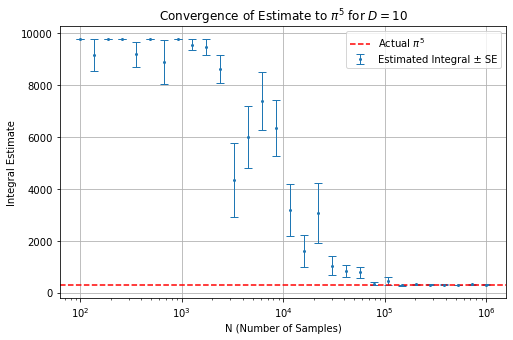

In [26]:

#Plot

plt.figure(figsize=(8, 5))
plt.errorbar(N_values, integral_estimates, yerr=std_errors, fmt='o', markersize=2, capsize=4, elinewidth=1, capthick=1, label='Estimated Integral ± SE')
plt.axhline(y=actual_value, color='red', linestyle='--', label=r'Actual $\pi^{5}$')
plt.xscale('log')
plt.xlabel('N (Number of Samples)')
plt.ylabel('Integral Estimate')
plt.title(r'Convergence of Estimate to $\pi^{5}$ for $D=10$')
plt.legend()
plt.grid(True)
plt.show()

# Integral Estimate vs Step Size

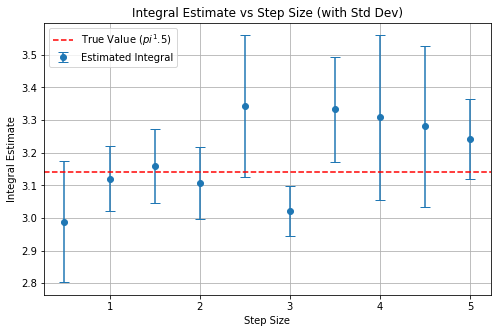

In [27]:

# Vary the step size, compute the integral multiple times for each, and show deviation from the true value
D = 2
N = 1_000
x0 = np.zeros(D)
thinning = 1
burnin = int(N * 0.1)
actual_value = np.pi ** (D/2)

step_sizes = np.linspace(0.5, 5.0, 10)
repeats = 5  # Number of runs per step size
means = []
stds = []

for step_size in step_sizes:
    estimates = []
    for _ in range(repeats):
        m_chain = metropolis_hastings(x0, thinning, burnin, N, step_size, target_pdf)
        estimate = importance_integration(f, target_pdf, m_chain)
        estimates.append(estimate)
    means.append(np.mean(estimates))
    stds.append(np.std(estimates))

plt.figure(figsize=(8, 5))
plt.errorbar(step_sizes, means, yerr=stds, fmt='o', markersize=6, capsize=5, label='Estimated Integral')
plt.axhline(y=actual_value, color='red', linestyle='--', label=f'True Value ($pi^{3/2}$)')
plt.xlabel('Step Size')
plt.ylabel('Integral Estimate')
plt.title('Integral Estimate vs Step Size (with Std Dev)')
plt.legend()
plt.grid(True)
plt.show()


# Visualize how the integral estimate evolves during the burn-in period

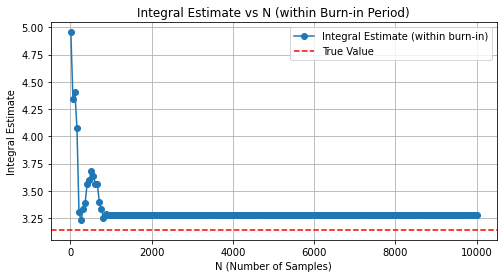

In [28]:
# Visualize how the integral estimate evolves during the burn-in period

burn_in = 10_000
N_checkpoints = np.linspace(10, burn_in, 200, dtype=int)
estimates = []

for n in N_checkpoints:
    # Estimate the integral using the first n samples (within burn-in)
    values = [f(x) / target_pdf(x) for x in m_chain[:n]] if 'm_chain' in locals() else []
    if values:
        estimate = np.mean(values)
        estimates.append(estimate)
    else:
        estimates.append(np.nan)

actual_value = np.pi ** (D/2) if 'D' in locals() else 1.0

plt.figure(figsize=(8, 4))
plt.plot(N_checkpoints, estimates, marker='o', label='Integral Estimate (within burn-in)')
plt.axhline(y=actual_value, color='red', linestyle='--', label='True Value')
plt.xlabel('N (Number of Samples)')
plt.ylabel('Integral Estimate')
plt.title('Integral Estimate vs N (within Burn-in Period)')
plt.legend()
plt.grid(True)
plt.show()

# Heat Map of Markov Chain vs Analytical Target pdf

In [29]:
# Only run for D=2
D = 2
N = 1_000_000
x0 = np.zeros(D)
step_size = 3.0
thinning = 1
burnin = int(N * 0.1)

m_chain = metropolis_hastings(x0, thinning, burnin, N, step_size, target_pdf)


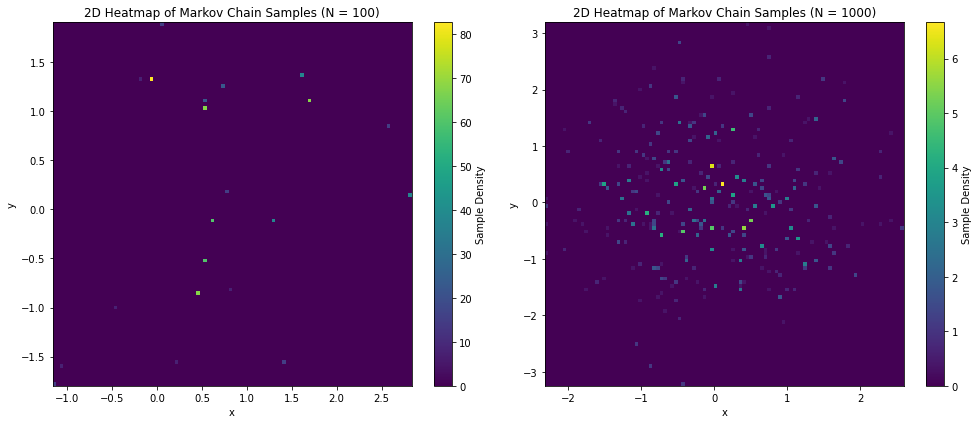

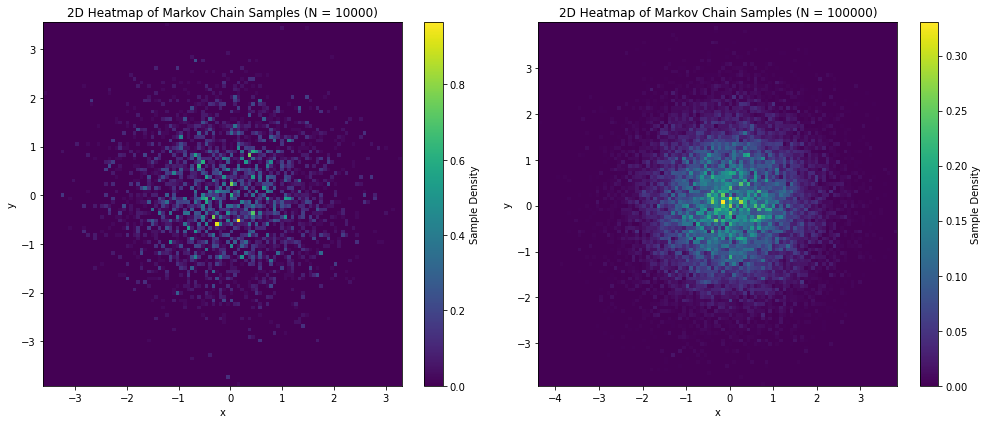

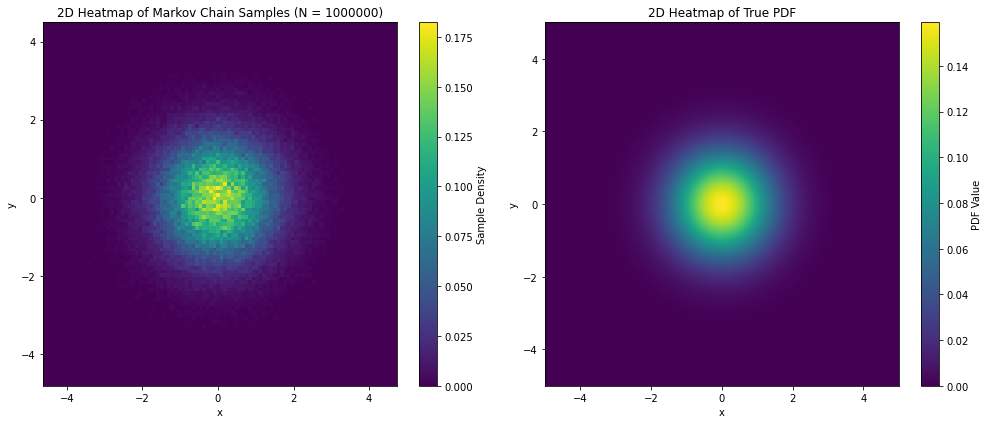

"\n# Plot Markov chain sample heatmap\nh1 = axs[0].hist2d(x_vals, y_vals, bins=100, cmap='viridis', density=True)\nplt.colorbar(h1[3], ax=axs[0], label='Sample Density')\naxs[0].set_xlabel('x')\naxs[0].set_ylabel('y')\naxs[0].set_title('2D Heatmap of Markov Chain Samples (D=2)')\n\n# Plot true PDF heatmap\ngrid_size = 200\nx_grid = np.linspace(-5, 5, grid_size)\ny_grid = np.linspace(-5, 5, grid_size)\nX, Y = np.meshgrid(x_grid, y_grid)\npos = np.dstack((X, Y))\nZ = target_pdf(pos)\n\nim = axs[1].imshow(Z, extent=[-5, 5, -5, 5], origin='lower', cmap='viridis', aspect='auto')\nplt.colorbar(im, ax=axs[1], label='PDF Value')\naxs[1].set_xlabel('x')\naxs[1].set_ylabel('y')\naxs[1].set_title('2D Heatmap of True PDF (D=2)')\n\nplt.tight_layout()\nplt.show()\n"

In [30]:
"""
# Extract x and y coordinates
x_vals = m_chain[:, 0]
y_vals = m_chain[:, 1]

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
"""
N_values = [100,1_000,10_000, 100_000, 1_000_000]
i = 0
for N in N_values:
    D = 2
    q = i % 2
    x0 = np.zeros(D)
    step_size = 3.0
    thinning = 1
    burnin = int(N * 0.1)
    m_chain = metropolis_hastings(x0, thinning, burnin, int(N), step_size, target_pdf)
    
    x_vals = m_chain[:, 0]
    y_vals = m_chain[:, 1]

    if q == 0:
        fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Plot Markov chain sample heatmap
    h1 = axs[q].hist2d(x_vals, y_vals, bins=100, cmap='viridis', density=True)
    plt.colorbar(h1[3], ax=axs[q], label='Sample Density')
    axs[q].set_xlabel('x')
    axs[q].set_ylabel('y')
    axs[q].set_title(f'2D Heatmap of Markov Chain Samples (N = {N})')
    if q == 1:
        plt.tight_layout()
        plt.show()
    i+=1

# Plot true PDF heatmap
grid_size = 200
x_grid = np.linspace(-5, 5, grid_size)
y_grid = np.linspace(-5, 5, grid_size)
X, Y = np.meshgrid(x_grid, y_grid)
pos = np.dstack((X, Y))
Z = target_pdf(pos)

im = axs[1].imshow(Z, extent=[-5, 5, -5, 5], origin='lower', cmap='viridis', aspect='auto')
plt.colorbar(im, ax=axs[1], label='PDF Value')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].set_title('2D Heatmap of True PDF')

plt.tight_layout()
plt.show()
"""
# Plot Markov chain sample heatmap
h1 = axs[0].hist2d(x_vals, y_vals, bins=100, cmap='viridis', density=True)
plt.colorbar(h1[3], ax=axs[0], label='Sample Density')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_title('2D Heatmap of Markov Chain Samples (D=2)')

# Plot true PDF heatmap
grid_size = 200
x_grid = np.linspace(-5, 5, grid_size)
y_grid = np.linspace(-5, 5, grid_size)
X, Y = np.meshgrid(x_grid, y_grid)
pos = np.dstack((X, Y))
Z = target_pdf(pos)

im = axs[1].imshow(Z, extent=[-5, 5, -5, 5], origin='lower', cmap='viridis', aspect='auto')
plt.colorbar(im, ax=axs[1], label='PDF Value')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].set_title('2D Heatmap of True PDF (D=2)')

plt.tight_layout()
plt.show()
"""

# Bin the Markov Chain into Chunks of Size H
This cell divides the Markov chain into bins of size H and computes the mean of each bin. The result is an array of binned means for further analysis (e.g., to estimate standard error with binning).

In [31]:
# Generate the markov chain
D = 2
x0 = np.zeros(D)
thinning = 1
burnin = 0
N = 100_000
step_size = 3
markov_chain = metropolis_hastings(x0, thinning, burnin, N, step_size, target_pdf)

actual_value = np.pi ** (D / 2)
# Choose bin size H
H = 1000  # You can change this value as needed

# Ensure markov_chain is available

H_values = [10,50,100,250,500,750,1000,]
Variances = []
num_repeats = 10


for H in H_values:
    N = len(markov_chain)
    n_bins = N // int(H)
    # Truncate the chain to a multiple of H
    truncated_chain = markov_chain[:n_bins * int(H)]
    # Reshape and compute mean for each bin
    binned_means = truncated_chain.reshape(n_bins, int(H), -1).mean(axis=1)
    Variances.append(np.var(binned_means))

# Conway Bin Analysis


In [32]:
#Blocking Variance

def blocking_variance(series, min_blocks=4):
    """
    Return
        bin_sizes  – powers-of-2 block lengths
        var_mean   – variance of the MCMC mean at each block size
        err_var    – 1-σ uncertainty of that variance
    """
    N = len(series)
    max_power = int(np.log2(N // min_blocks))
    bin_sizes = 2 ** np.arange(max_power + 1)

    var_mean, err_var = [], []
    for L in bin_sizes:
        n_blocks = N // L
        if n_blocks < min_blocks:               # need ≥ min_blocks estimates
            break
        # reshape   → one mean per block
        blocks = series[:n_blocks * L].reshape(n_blocks, L).mean(axis=1)

        s2      = blocks.var(ddof=1)            # unbiased σ² of block means
        v_mean  = s2 / n_blocks                 # Var[overall mean]
        var_mean.append(v_mean)

        # 1-σ error bar from χ² statistics
        err_var.append(v_mean * np.sqrt(2 / (n_blocks - 1)))

    return bin_sizes[:len(var_mean)], np.array(var_mean), np.array(err_var)

In [33]:
# ------------------------------------------------------------
# tiny plateau finder
# ------------------------------------------------------------

def plateau_variance(bin_sizes, variances, window=3, tolerance=0.04):
    """
    Mean of first 'window' consecutive points whose relative stdev < tolerance.
    Returns (variance_est, index_of_rightmost_point).
    """
    if len(variances) < window:
        return variances[-1], len(variances) - 1

    for i in range(len(variances) - window + 1):
        w = variances[i:i + window]
        if np.std(w) / np.mean(w) < tolerance:
            return np.mean(w), i + window - 1
    # fallback: last point
    return variances[-1], len(variances) - 1

In [34]:
# --- 0. parameters ----------------------------------------
D = 2
N = 100_000  # Number of samples
step_size = 3  # Step size for the proposal distribution
x0 = np.zeros(D)  # Initial point for the Markov chain rng.uniform(-step_size, step_size)
burnin = 0.1*N  # Number of samples to discard as burn-in
thinning = 2  # Thinning factor for the Markov chain

# --- 1. generate a correlated chain (AR(1)) -----------------
markov_chain = metropolis_hastings(x0, thinning, burnin, N, step_size, target_pdf)

f_i = f(markov_chain)/ target_pdf(markov_chain)  # Importance weights for the samples

# --- 2. blocking analysis with error bars ------------------
bin_sizes, vars_mean, errs = blocking_variance(f_i)

# automatic plateau estimate
v_hat, idx = plateau_variance(bin_sizes, vars_mean)
err_hat    = errs[idx]

print("======  blocking-plateau variance estimate  ======")
print(f"Var[mean] ≈ {v_hat:.4e}  ± {err_hat:.1e}")
print(f"Std error ≈ {np.sqrt(v_hat):.4e}")

# 2. plot ----------------------------------------------------
plt.figure(figsize=(8, 6))
plt.errorbar(bin_sizes, vars_mean, yerr=errs,
             fmt='-s', capsize=3, linewidth=1, markersize=4,
             label='blocking estimate')
plt.scatter(bin_sizes[idx], v_hat, s=80, color='red',
            label='plateau pick')

# <<< NEW: horizontal line through the plateau value >>>
plt.axhline(v_hat, color='k', linestyle='--', linewidth=1,
            label=f'plateau variance ≈ {v_hat:.2e}')

plt.xscale('log'); plt.yscale('log')
plt.xlabel("Bin size $L$")
plt.ylabel(r"Var[$\hat\mu$]")
plt.title("Variance of MCMC mean vs. block size\n(1-σ error bars)")
plt.legend()
plt.tight_layout()
plt.text(bin_sizes[0], v_hat, f"Step size: {step_size}", fontsize=10, color='blue', verticalalignment='bottom')
plt.savefig(f"plots/Variance_of_MCMC_mean_vs_block_size_step={step_size}.pdf", format="pdf")
plt.show()
plt.close()


TypeError: slice indices must be integers or None or have an __index__ method